# Sentdex

This notebook is inspired by [How to Get an Allocation: Writing an Algorithm for the Quantopian Investment Management Team](https://www.quantopian.com/posts/how-to-get-an-allocation-writing-an-algorithm-for-the-quantopian-investment-management-team) by Jamie McCorriston.

[Sentdex Sentiment Analysis](https://www.quantopian.com/data/sentdex/sentiment)

Assesses the sentiment of companies by pulling from over 20 sources such as Wall Street Journal, CNBC, Forbes, Business Insider, and Yahoo Finance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import blaze as bz
from zipline.utils.tradingcalendar import get_trading_days

from quantopian.interactive.data.sentdex import sentiment

In [2]:
type(sentiment)

<class 'blaze.expr.expressions.Field'>

In [3]:
sentiment.fields

[u'symbol', u'sentiment_signal', u'sid', u'asof_date', u'timestamp']

In [4]:
sentiment.sentiment_signal

,sentiment_signal
0,6.0
1,2.0
2,6.0
3,6.0
4,6.0
5,6.0
6,1.0
7,-1.0
8,6.0
9,-3.0


In [5]:
sentiment

,symbol,sentiment_signal,sid,asof_date,timestamp
0,AAPL,6.0,24,2012-10-15,2012-10-16
1,AAPL,2.0,24,2012-10-16,2012-10-17
2,AAPL,6.0,24,2012-10-17,2012-10-18
3,AAPL,6.0,24,2012-10-18,2012-10-19
4,AAPL,6.0,24,2012-10-19,2012-10-20
5,AAPL,6.0,24,2012-10-20,2012-10-21
6,AAPL,1.0,24,2012-10-21,2012-10-22
7,AAPL,-1.0,24,2012-10-22,2012-10-23
8,MSFT,6.0,5061,2012-10-22,2012-10-23
9,AAPL,-3.0,24,2012-10-23,2012-10-24


# Extract to explore data

In [6]:
sentdex = bz.compute(sentiment.sentiment_signal)

In [7]:
type(sentdex)

<class 'pandas.core.series.Series'>

In [8]:
sentdex.head()

0    6.0
1    2.0
2    6.0
3    6.0
4    6.0
Name: sentiment_signal, dtype: float64

In [9]:
sentdex.describe()

count    10001.000000
mean         3.396860
std          2.858424
min         -3.000000
25%          1.000000
50%          4.000000
75%          6.000000
max          6.000000
Name: sentiment_signal, dtype: float64

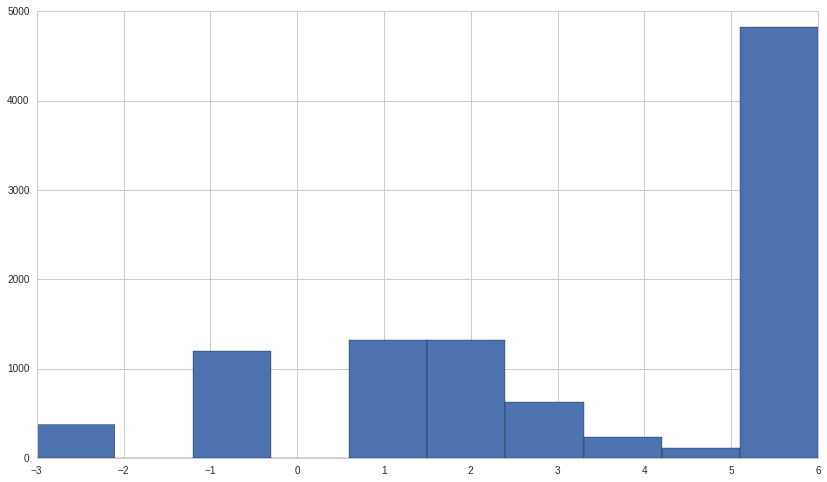

In [10]:
sentdex.hist(bins=10);

# Apple

In [11]:
aapl_sid = symbols('AAPL').sid

In [12]:
sentiment[(sentiment.sid == aapl_sid)].peek()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,AAPL,6.0,24,2012-10-15,2012-10-16
1,AAPL,2.0,24,2012-10-16,2012-10-17
2,AAPL,6.0,24,2012-10-17,2012-10-18
3,AAPL,6.0,24,2012-10-18,2012-10-19
4,AAPL,6.0,24,2012-10-19,2012-10-20
5,AAPL,6.0,24,2012-10-20,2012-10-21
6,AAPL,1.0,24,2012-10-21,2012-10-22
7,AAPL,-1.0,24,2012-10-22,2012-10-23
8,AAPL,-3.0,24,2012-10-23,2012-10-24
9,AAPL,-1.0,24,2012-10-24,2012-10-25


In [13]:
sentiment[(sentiment.sid == aapl_sid) & (sentiment.asof_date >= '2013-12-01')].peek()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,AAPL,1.0,24,2013-12-01,2013-12-02
1,AAPL,6.0,24,2013-12-02,2013-12-03
2,AAPL,5.0,24,2013-12-03,2013-12-04
3,AAPL,6.0,24,2013-12-04,2013-12-05
4,AAPL,4.0,24,2013-12-05,2013-12-06
5,AAPL,2.0,24,2013-12-06,2013-12-07
6,AAPL,-1.0,24,2013-12-07,2013-12-08
7,AAPL,-1.0,24,2013-12-08,2013-12-09
8,AAPL,-3.0,24,2013-12-09,2013-12-10
9,AAPL,-1.0,24,2013-12-10,2013-12-11


In [14]:
date_mask = (sentiment.asof_date >= '2013-12-01') & (sentiment.asof_date <= '2014-12-01')

In [15]:
stock_mask = (sentiment.sid == aapl_sid)

In [16]:
sentiment_2014_expr = sentiment[date_mask & stock_mask].sort('asof_date')

In [17]:
sentiment_2014_df = bz.compute(sentiment_2014_expr)

In [18]:
sentiment_2014_df.columns

Index([u'symbol', u'sentiment_signal', u'sid', u'asof_date', u'timestamp'], dtype='object')

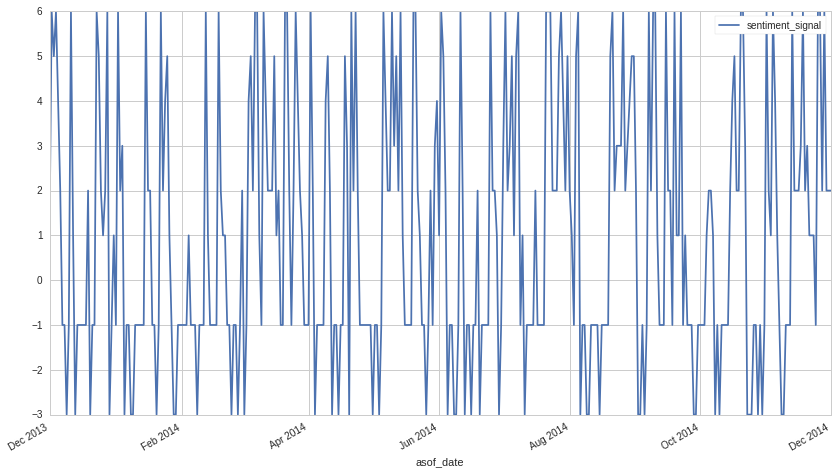

In [19]:
sentiment_2014_df.plot(x='asof_date', y='sentiment_signal');

***

## Part 2 - Define Our Factor
Now that we have a dataset that we want to use, let's use it in a [pipeline](https://www.quantopian.com/tutorials/pipeline). 

In addition to the sentiment dataset, we will also use 

   * [EventVestor Earnings Calendar](https://www.quantopian.com/data/eventvestor/earnings_calendar) dataset to [avoid trading around earnings announcements](https://www.quantopian.com/posts/event-study-the-rising-impact-of-earnings-on-stock-returns)
   
   * [EventVestor Mergers & Acquisitions](https://www.quantopian.com/data/eventvestor/mergers_and_acquisitions) dataset to avoid trading acquisition targets. 
   
   
We will work with the free versions of these datasets.

In [20]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment

# EventVestor Earnings Calendar free from 01 Feb 2007 to 1 year ago.
from quantopian.pipeline.factors.eventvestor import (
    BusinessDaysUntilNextEarnings,
    BusinessDaysSincePreviousEarnings,
)

# EventVestor Mergers & Acquisitions free from 01 Feb 2007 to 1 year ago.
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget

from quantopian.pipeline.factors import BusinessDaysSincePreviousEvent

In [21]:
def make_pipeline():
    
    sentiment_factor = sentiment.sentiment_signal.latest

    # Filter for stocks that are not within 2 days of an earnings announcement.
    not_near_earnings_announcement = ~((BusinessDaysUntilNextEarnings() <= 2)
                                     |(BusinessDaysSincePreviousEarnings() <= 2))
    
    # Filter for stocks that are announced acquisition target.
    not_announced_acq_target = ~IsAnnouncedAcqTarget()
    
    # Filter for stocks that had their sentiment signal updated in the last day.
    new_info = (BusinessDaysSincePreviousEvent(inputs=[sentiment.asof_date.latest]) <= 1)
    
    # Our universe is made up of stocks that have a non-null sentiment signal that was updated in
    # the last day, are not within 2 days of an earnings announcement, are not announced acquisition
    # targets, and are in the Q1500US.
    universe = (Q1500US() 
                & sentiment_factor.notnull() 
                & not_near_earnings_announcement
                & not_announced_acq_target
                & new_info)
    
    # Our pipeline is defined to have the rank of the sentiment_factor as the only column. It is
    # screened by our universe filter.
    pipe = Pipeline(
        columns={
            'sentiment': sentiment_factor.rank(mask=universe, method='average'),
        },
        screen=universe
    )
    
    return pipe

In [22]:
result = run_pipeline(make_pipeline(), start_date='2013-12-01', end_date='2014-12-01')

In [23]:
result.head()

sentiment
2013-12-02 00:00:00+00:00 Equity(2 [ARNC])       167.0
                          Equity(24 [AAPL])      167.0
                          Equity(62 [ABT])       430.5
                          Equity(67 [ADSK])      430.5
                          Equity(76 [TAP])       223.0

## Part 3 - Analyze Our Factor Using Alphalens

In [24]:
assets = result.index.levels[1].unique()

In [28]:
pricing = get_pricing(assets, start_date='2013-12-01', end_date='2015-01-01', fields='open_price')

In [29]:
import alphalens

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated and will be removed in the future. Please use the new API instead.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,4.5,304.0,136.383286,73.953697,67434,56.901047
2,191.0,478.0,372.196321,64.993659,51077,43.098953


Returns Analysis


,1,5,10
Ann. alpha,0.019,0.014,0.003
beta,-0.012,-0.025,-0.017
Mean Period Wise Return Top Quantile (bps),0.884,2.518,1.148
Mean Period Wise Return Bottom Quantile (bps),-0.670,-1.908,-0.870
Mean Period Wise Spread (bps),1.311,0.702,-0.013


Information Analysis


,1,5,10
IC Mean,0.006,0.007,-0.001
IC Std.,0.052,0.055,0.059
t-stat(IC),1.734,1.909,-0.294
p-value(IC),0.084,0.057,0.769
IC Skew,-0.031,0.015,-0.546
IC Kurtosis,0.184,0.236,0.807
Ann. IR,1.734,1.909,-0.294


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.077,0.244,0.306
Quantile 2 Mean Turnover,0.095,0.290,0.377


,1,5,10
Mean Factor Rank Autocorrelation,0.926,0.729,0.569


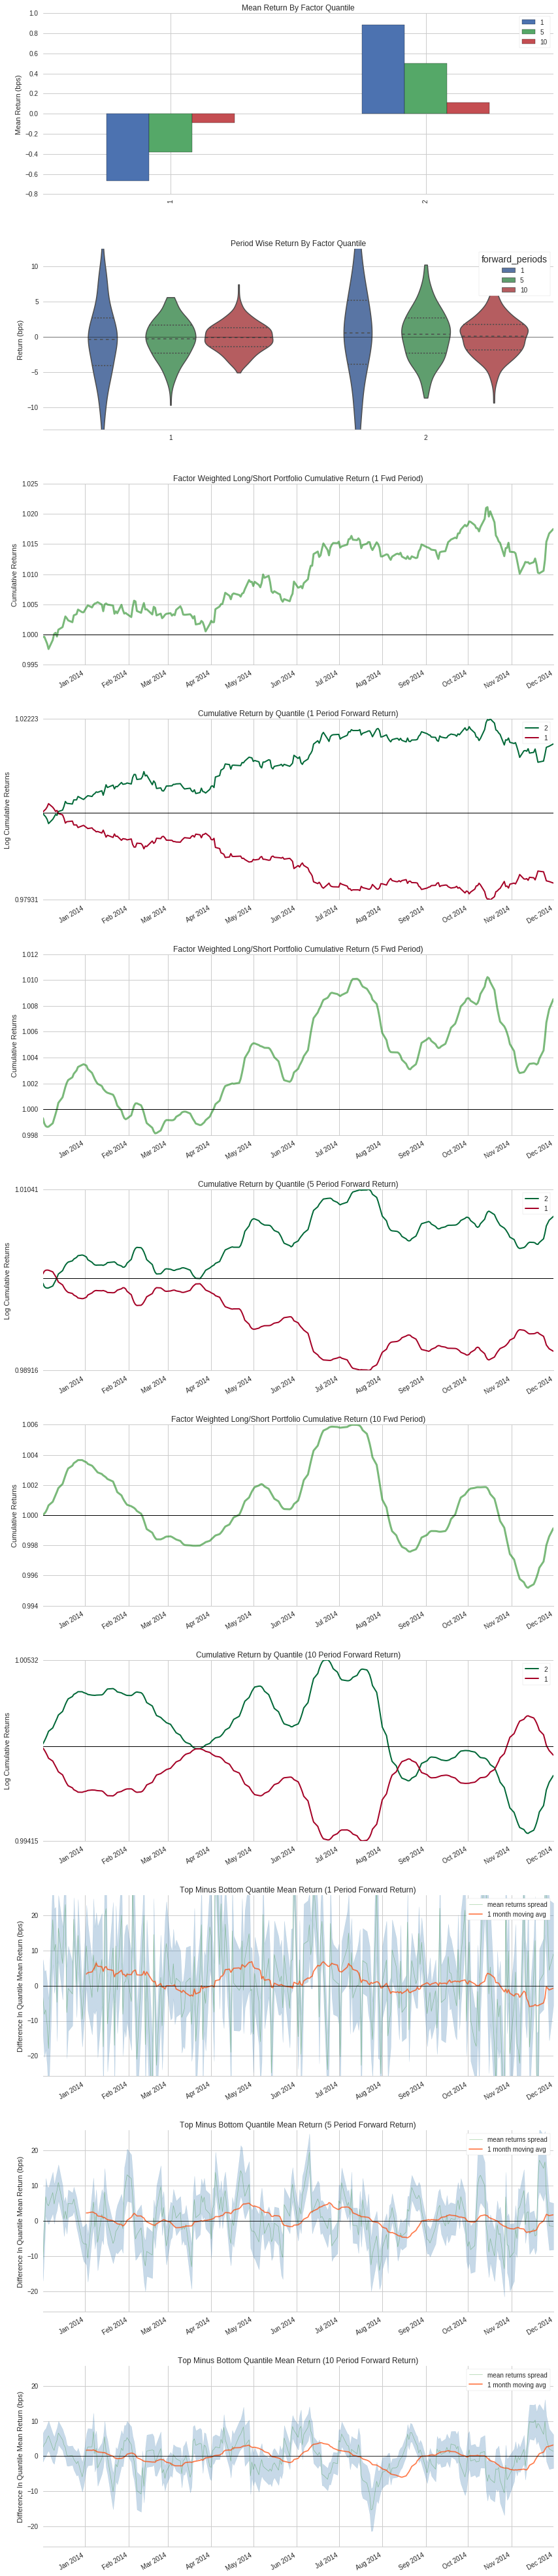

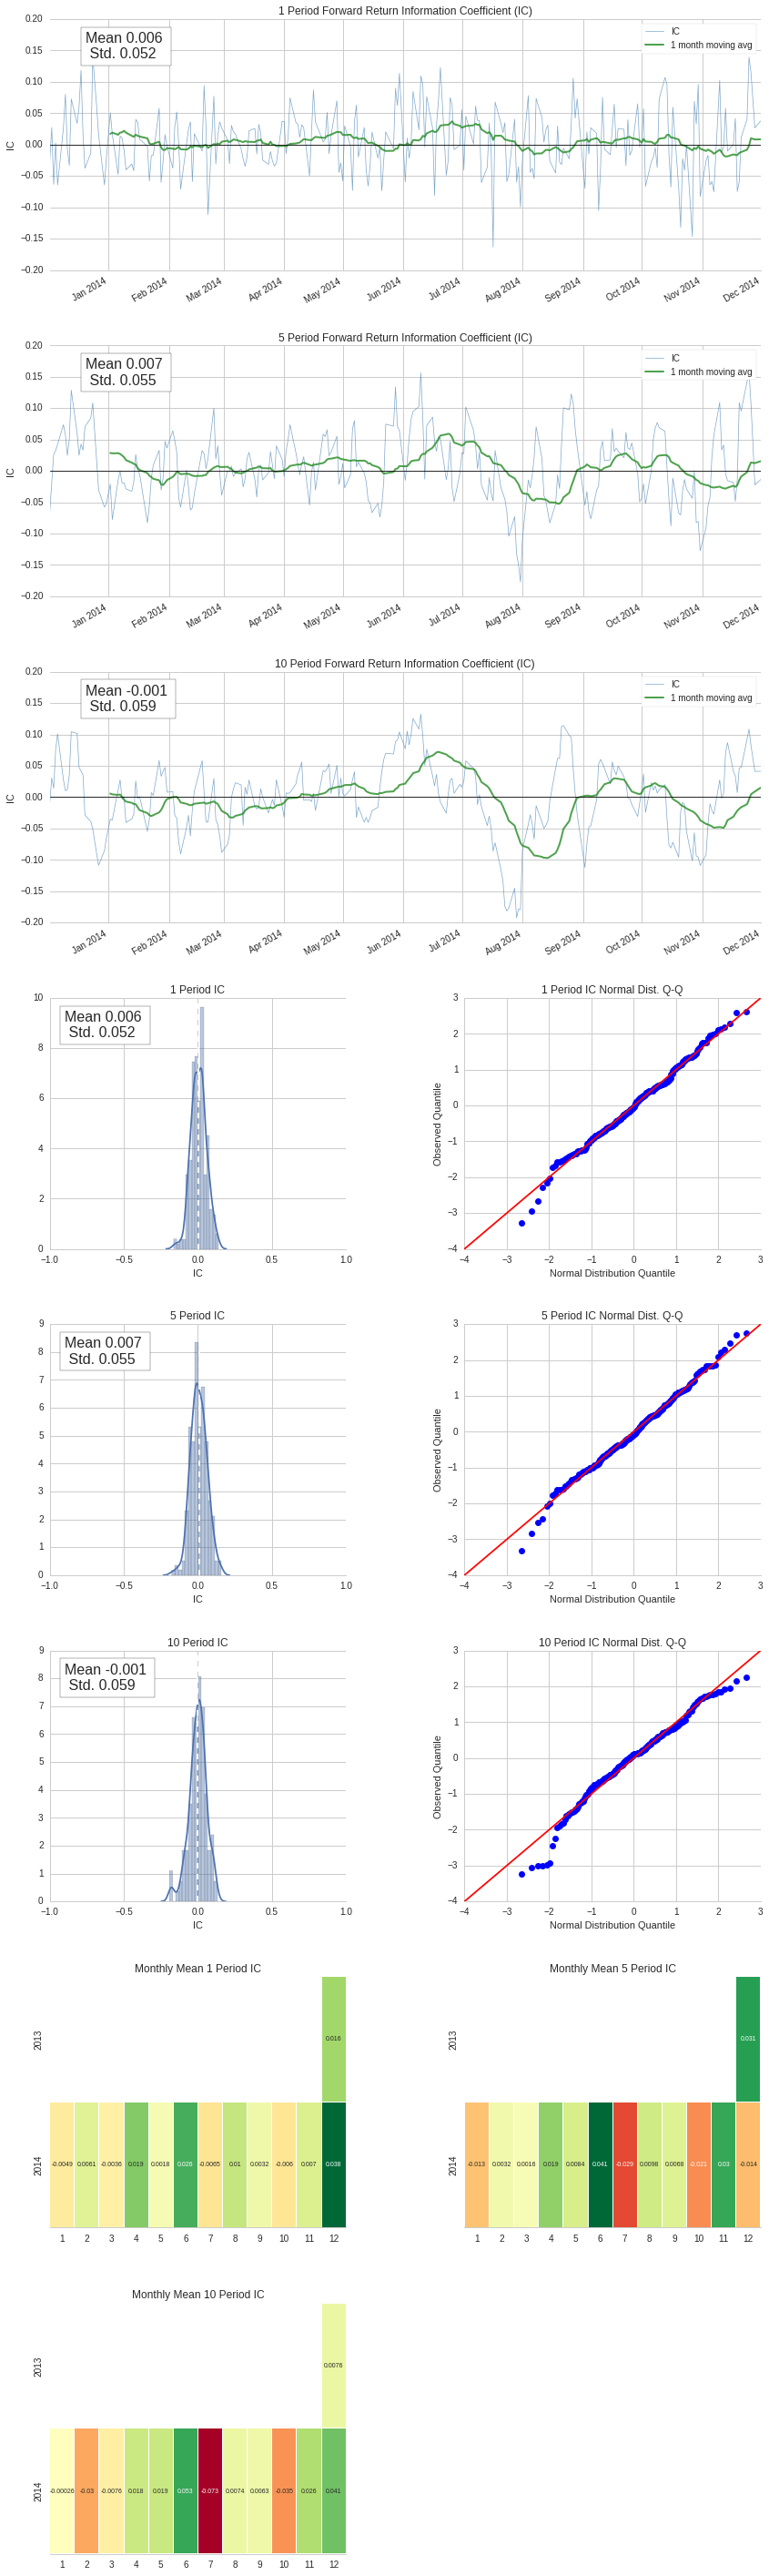

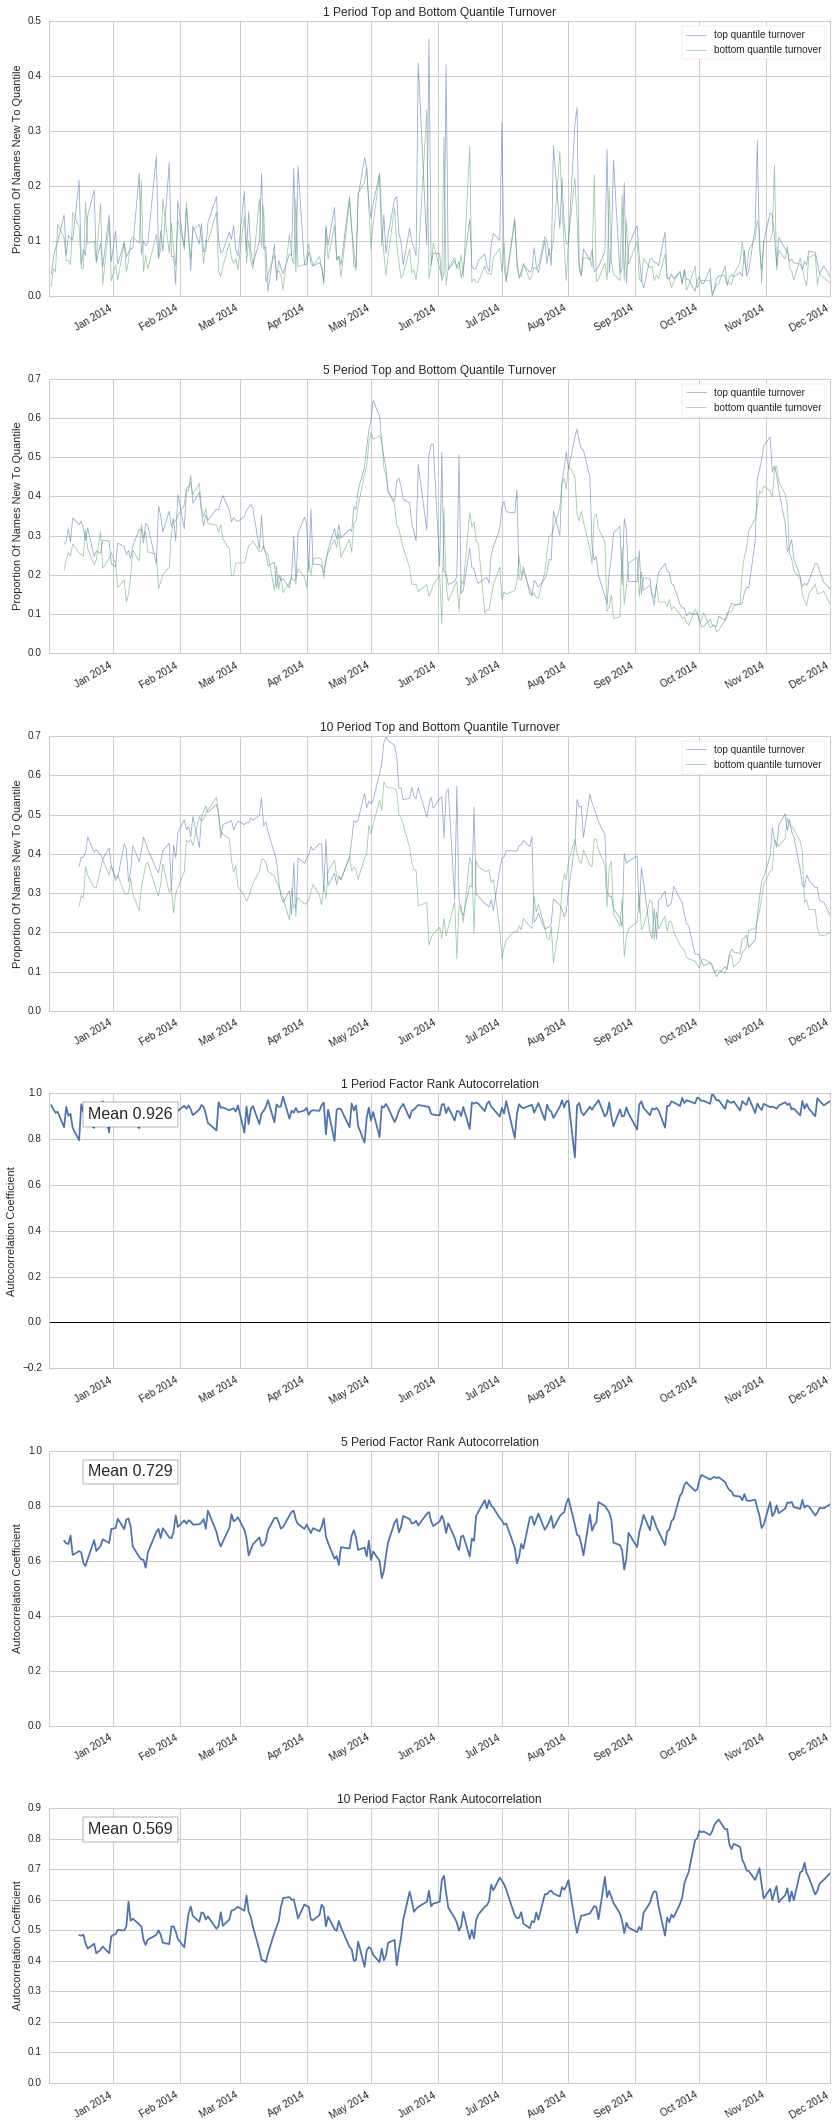

In [30]:
alphalens.tears.create_factor_tear_sheet(factor=result['sentiment'],
                                         prices=pricing,
                                         quantiles=2,
                                         periods=(1,5,10))